In [1]:
import json
import pathlib

import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

DATA_DIR = pathlib.Path('../data')

## Optimal

In [2]:
with (DATA_DIR / 'boardOptimals.json').open() as f:
    optimal = json.load(f)

## Load data

In [3]:
def load_data(filepath):
    with open(filepath) as f:
        return json.load(f)

In [4]:
def to_record(experiment):
    return {
        'board_id': experiment['gs']['boardID'],
        'ticks': experiment['gs']['tick'],
        'impossible_actions': experiment['gs']['impossibleActionCount'],
        'first_winner_tick': experiment['gs']['firstWinnerTick'],
        'heuristic': experiment['agentsParams'][0]['heuristic_method'],
    }

In [5]:
df = pd.DataFrame.from_records(to_record(x) for x in load_data(DATA_DIR / '100_ticks.json'))
df['success'] = df['ticks'] < 100
df['second_winner_lag'] = df['ticks'] - df['first_winner_tick']
df['solo'] = (df['heuristic'] % 2).astype(bool)
df['binary'] = df['heuristic'] < 3

def is_optimal(experiment):
    for board in optimal['boards']:
        if board['boardID'] == experiment['board_id']:
            return experiment['ticks'] <= board['tick']
    raise AssertionError("Shouldn't happen")

df['optimal'] = df.apply(is_optimal, axis=1)

## Success percentage

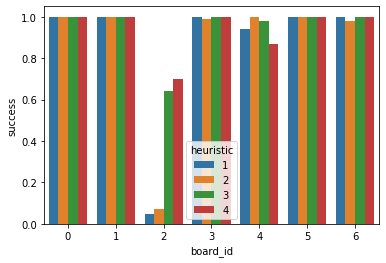

In [6]:
sns.barplot(
    y='success',
    x='board_id',
    hue='heuristic',
    data=df.groupby(['board_id', 'heuristic'])['success'].mean().reset_index(),
)

## Analysis including failures

### Ticks

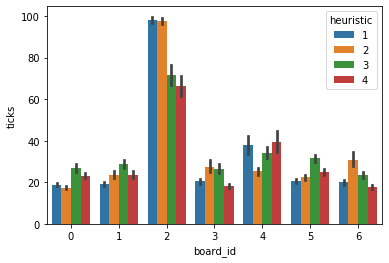

In [7]:
sns.barplot(
    y='ticks',
    x='board_id',
    hue='heuristic',
    data=df,
)

### Impossible actions

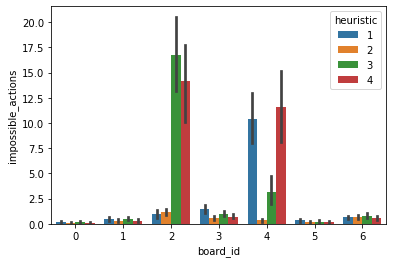

In [8]:
sns.barplot(
    y='impossible_actions',
    x='board_id',
    hue='heuristic',
    data=df,
)

### 2nd winner lag

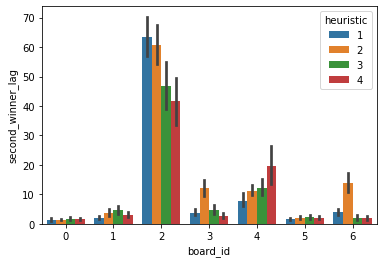

In [9]:
sns.barplot(
    y='second_winner_lag',
    x='board_id',
    hue='heuristic',
    data=df,
)

## Successfull runs only

### Ticks

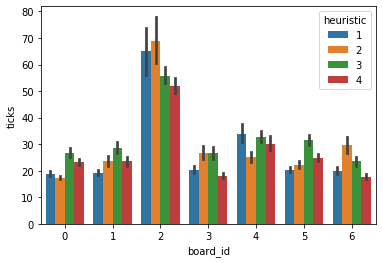

In [10]:
sns.barplot(
    y='ticks',
    x='board_id',
    hue='heuristic',
    data=df[df['success']],
)

### Impossible actions

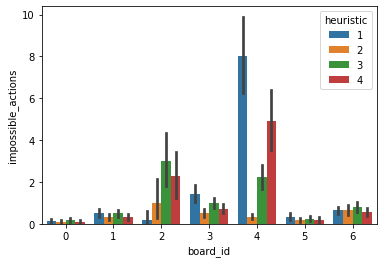

In [11]:
sns.barplot(
    y='impossible_actions',
    x='board_id',
    hue='heuristic',
    data=df[df['success']],
)

### 2nd winner lag

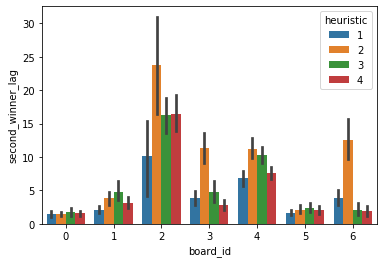

In [12]:
sns.barplot(
    y='second_winner_lag',
    x='board_id',
    hue='heuristic',
    data=df[df['success']],
)

## Is the number of ticks different between solo and joint

In [13]:
stats.ttest_ind(df['ticks'][df['solo'] == True], df['ticks'][df['solo'] == False])

Ttest_indResult(statistic=1.5312563789622535, pvalue=0.12581908907763859)

## Percentage optimal

In [14]:
df['optimal'].mean()

0.0017857142857142857

In [15]:
df[df['success']].groupby('heuristic').mean()

,board_id,first_winner_tick,impossible_actions,ticks,success,second_winner_lag,solo,binary,optimal
heuristic,,,,,,,,,
1,3.148581,19.118531,1.781302,22.419032,1.0,3.300501,1.0,1.0,0.000000
2,3.144040,17.395695,0.355960,24.672185,1.0,7.276490,0.0,1.0,0.006623
3,3.051360,25.456193,1.034743,30.980363,1.0,5.524169,1.0,0.0,0.000000
4,3.025875,21.382040,1.179604,25.881279,1.0,4.499239,0.0,0.0,0.001522


# ANOVAAAAAAAAA!

### ticks ~ heuristic * board

In [16]:
lm = ols('ticks ~ C(heuristic) * C(board_id)', data=df).fit()

In [17]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  ticks   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     329.1
Date:                Thu, 13 Jun 2019   Prob (F-statistic):               0.00
Time:                        13:13:04   Log-Likelihood:                -10984.
No. Observations:                2800   AIC:                         2.202e+04
Df Residuals:                    2772   BIC:                         2.219e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             18.9200      1.229     15.392      0.000      16.510      21.330
C(heuristic)[T.2]                     -1.4500      1.738     -0.834      0.404      -4.859       1.959
C(heuristic)[T.3]                      7.8800      1.738      4.533      0.000       4.471      11.289
C(heuristic)[T.4]                      4.2500      1.738      2.445      0.015       0.841       7.659
C(board_id)[T.1]                       0.3400      1.738      0.196      0.845      -3.069       3.749
C(board_id)[T.2]                      79.3400      1.738     45.642      0.000      75.931      82.749
C(board_id)[T.3]                       1.5100      1.738      0.869      0.385      -1.899       4.919
C(board_id)[T.4]                      19.0300      1.738     10.947      0.000      15.621      22.439
C(board_id)[T.5]                       1.5100      1.738      0.869      0.385      -1.899       4.919
C(board_id)[T.6]                       1.1200      1.738      0.644      0.519      -2.289       4.529
C(heuristic)[T.2]:C(board_id)[T.1]     5.7900      2.458      2.355      0.019       0.970      10.610
C(heuristic)[T.3]:C(board_id)[T.1]     1.6100      2.458      0.655      0.513      -3.210       6.430
C(heuristic)[T.4]:C(board_id)[T.1]     0.0700      2.458      0.028      0.977      -4.750       4.890
C(heuristic)[T.2]:C(board_id)[T.2]     1.0000      2.458      0.407      0.684      -3.820       5.820
C(heuristic)[T.3]:C(board_id)[T.2]   -34.4600      2.458    -14.017      0.000     -39.280     -29.640
C(heuristic)[T.4]:C(board_id)[T.2]   -36.2400      2.458    -14.741      0.000     -41.060     -31.420
C(heuristic)[T.2]:C(board_id)[T.3]     8.5300      2.458      3.470      0.001       3.710      13.350
C(heuristic)[T.3]:C(board_id)[T.3]    -1.7000      2.458     -0.692      0.489      -6.520       3.120
C(heuristic)[T.4]:C(board_id)[T.3]    -6.5700      2.458     -2.673      0.008     -11.390      -1.750
C(heuristic)[T.2]:C(board_id)[T.4]   -11.2300      2.458     -4.568      0.000     -16.050      -6.410
C(heuristic)[T.3]:C(board_id)[T.4]   -11.7100      2.458     -4.763      0.000     -16.530      -6.890
C(heuristic)[T.4]:C(board_id)[T.4]    -2.8900      2.458     -1.176      0.240      -7.710       1.930
C(heuristic)[T.2]:C(board_id)[T.5]     3.3900      2.458      1.379      0.168      -1.430       8.210
C(heuristic)[T.3]:C(board_id)[T.5]     3.2800      2.458      1.334      0.182      -1.540       8.100
C(heuristic)[T.4]:C(board_id)[T.5]     0.1000      2.458      0.041      0.968      -4.720       4.920
C(heuristic)[T.2]:C(board_id)[T.6]    12.4000      2.458      5.044      0.000       7.580      17.220
C(heuristic)[T.3]:C(board_id)[T.6]    -4.3800      2.458     -1.782      0.075      -9.200      

In [18]:
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
C(heuristic),9.214369e+03,3.0,20.328729,4.982996e-13
C(board_id),1.211099e+06,6.0,1335.963057,0.000000e+00
C(heuristic):C(board_id),1.220516e+05,18.0,44.878342,2.738763e-139
Residual,4.188199e+05,2772.0,NaN,NaN


In [19]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  ticks   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     329.1
Date:                Thu, 13 Jun 2019   Prob (F-statistic):               0.00
Time:                        13:13:04   Log-Likelihood:                -10984.
No. Observations:                2800   AIC:                         2.202e+04
Df Residuals:                    2772   BIC:                         2.219e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             18.9200      1.229     15.392      0.000      16.510      21.330
C(heuristic)[T.2]                     -1.4500      1.738     -0.834      0.404      -4.859       1.959
C(heuristic)[T.3]                      7.8800      1.738      4.533      0.000       4.471      11.289
C(heuristic)[T.4]                      4.2500      1.738      2.445      0.015       0.841       7.659
C(board_id)[T.1]                       0.3400      1.738      0.196      0.845      -3.069       3.749
C(board_id)[T.2]                      79.3400      1.738     45.642      0.000      75.931      82.749
C(board_id)[T.3]                       1.5100      1.738      0.869      0.385      -1.899       4.919
C(board_id)[T.4]                      19.0300      1.738     10.947      0.000      15.621      22.439
C(board_id)[T.5]                       1.5100      1.738      0.869      0.385      -1.899       4.919
C(board_id)[T.6]                       1.1200      1.738      0.644      0.519      -2.289       4.529
C(heuristic)[T.2]:C(board_id)[T.1]     5.7900      2.458      2.355      0.019       0.970      10.610
C(heuristic)[T.3]:C(board_id)[T.1]     1.6100      2.458      0.655      0.513      -3.210       6.430
C(heuristic)[T.4]:C(board_id)[T.1]     0.0700      2.458      0.028      0.977      -4.750       4.890
C(heuristic)[T.2]:C(board_id)[T.2]     1.0000      2.458      0.407      0.684      -3.820       5.820
C(heuristic)[T.3]:C(board_id)[T.2]   -34.4600      2.458    -14.017      0.000     -39.280     -29.640
C(heuristic)[T.4]:C(board_id)[T.2]   -36.2400      2.458    -14.741      0.000     -41.060     -31.420
C(heuristic)[T.2]:C(board_id)[T.3]     8.5300      2.458      3.470      0.001       3.710      13.350
C(heuristic)[T.3]:C(board_id)[T.3]    -1.7000      2.458     -0.692      0.489      -6.520       3.120
C(heuristic)[T.4]:C(board_id)[T.3]    -6.5700      2.458     -2.673      0.008     -11.390      -1.750
C(heuristic)[T.2]:C(board_id)[T.4]   -11.2300      2.458     -4.568      0.000     -16.050      -6.410
C(heuristic)[T.3]:C(board_id)[T.4]   -11.7100      2.458     -4.763      0.000     -16.530      -6.890
C(heuristic)[T.4]:C(board_id)[T.4]    -2.8900      2.458     -1.176      0.240      -7.710       1.930
C(heuristic)[T.2]:C(board_id)[T.5]     3.3900      2.458      1.379      0.168      -1.430       8.210
C(heuristic)[T.3]:C(board_id)[T.5]     3.2800      2.458      1.334      0.182      -1.540       8.100
C(heuristic)[T.4]:C(board_id)[T.5]     0.1000      2.458      0.041      0.968      -4.720       4.920
C(heuristic)[T.2]:C(board_id)[T.6]    12.4000      2.458      5.044      0.000       7.580      17.220
C(heuristic)[T.3]:C(board_id)[T.6]    -4.3800      2.458     -1.782      0.075      -9.200      